# Разбираем EM-algorithm на маленькие кирпичики

В этой статье, как Вы уже, наверное догадались, речь пойдет об устройстве EM-алгоритма. Статья прежде всего может быть интересна тем, кто потихонечку уже вступает в сообщество датасайнтистов. Материал изложенный в статье в большей степени будет полезен тем, кто недавно начал проходить третий курс "Поиск структуры в данных" в рамках специализации "Машинное обучение и анализ данных" от МФТИ и Яндекс. 

Изложенный в статье материал, в каком-то смысле, является дополнением к первой недели обучения на вышеобозначенном курсе, а именно, позволяет ответить на некоторые немаловажные вопросы, касательно принципа действия EM-алгоритма. Для лучшего понимания материала нашему многоуважаемому читателю желательно уметь осуществлять операции с матрицами (умножение матриц, нахождение определителя матрицы и обратной матрицы), разбираться в основах теории вероятности и матстата, ну и конечно же, иметь хотя бы базовое представление о базовых алгоритмах кластеризации и понимать какое место кластеризация занимает в машинном обучении. Хотя, безусловно, и без этих знаний можно ознакомиться со статьей, что-то да наверняка будет понятным :)

Также по старой традиции, статья не будет содержать глубоких теоретических изысканий, но будет наполнена простыми и доступными для понимания примерами. Каждый последующий пример будет немного глубже предыдущего объяснять действие EM-алгоритма, что в конечном итоге приведет нас прямёхонько к разбору самого алгоритма. Для каждого примера будет написан код. Весь код написан на языке python 2.7, и за это я заранее приношу извинения. Так вышло, что сейчас я использую именно эту версию, но после перехода на python 3, постараюсь изменить код в статье. 

**Ознакомимся с планом статьи:**

1) Рассмотрим в общих чертах как устроен EM-алгоритм.

2) Повторим основные моменты из теоремы (формулы) Байеса: $$ P_{x_i}(B_j) = \frac{P(B_j) \centerdot P_{B_j}(x_i)}{P(x_i)} $$

3) Рассмотрим первый пример на теорему Байеса, в котором все элементы формулы (а точнее вероятности $P(B_j)$, $P_{B_j}(x_i)$) за знаком равенства справа известны. В этом случае нам требуется только правильно понять какие цифры куда подставить и далее выполнить элементарные операции.

4) Рассмотрим второй пример на теорему Байеса. Для решения задачи нам необходимо будет уже дополнительно вычислить плотность вероятности определенного события ($x_i$) при условии гипотезы ($B_j$) - $ \rho_{B_j}(x_i) $. Для вычислений нам будут даны параметры случайной величины, а именно, математическое ожидание - $\mu$ и стандартное отклонение - $\sigma$. Вычисления плотности вероятности будут осуществляться по следующей формуле:
$$ \rho_{B_j}(x_i) = \frac{1}{\sigma_j \centerdot \sqrt{2 \pi}} \centerdot \exp(- \frac{(x_i-\mu_j)^2}{2 \sigma_j^2}) $$
Использование вышеобозначенной формулы предполагает, что случайная величина имеет одномерное измерение и распределена нормально (иначе говорят - распределение Гаусса или Гаусса-Лапласа распределение вероятностей).

5) Рассмотрим третий пример, который отличается от предыдущего только тем, что в нем рассматривается случай многомерного (в нашем варианте двумерного) нормального распределения случайной величины. В таком случае вычисление плотностей осуществляется по следующей формуле:
$$ \rho_{B_j}(x_i) = \frac{1}{(2\pi)^{k/2} \centerdot \mid \Sigma_j\mid ^{1/2}} \centerdot \exp(- \frac{1}{2} \centerdot (x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j)) $$

6) И наконец, мы модифицируем третий пример таким образом, чтобы наглядно продемонстрировать работу EM-алгоритма.

7) В завершении, сравним качество работы выведенного нами алгоритма с качеством работы EM-алгоритма, который встроен в библиотеку sklearn (class sklearn.mixture.GaussianMixture)

Если Вы вместо формул, указанных в плане статьи, увидели японские иероглифы, то пожалуйста не пугайтесь - после теоремы Байеса (второго пункта плана статьи), мы будем разбирать такие примеры, которые Вы наверняка будете понимать, как минимум, на интуитивном уровне. Ну что же, погнали!

### EM-алгоритм в общих чертах

На курсе, по мотивам, которого написана статья, EM-алгоритм приводится в качестве одного из способов кластеризации. Другими словами, это метод машинного обучения без учителя, когда нам заранее не известны истинные ответы. В нашей статье, мы также будем рассматривать алгоритм в рамках одного из метода кластеризации случайной величины, имеющей нормальное распределение. Однако следует отметить, что алгоритм имеет более широкое применение. EM-алгоритм (англ. expectation-maximization) - это общий метод нахождения оценок функции правдоподобия в моделях со скрытыми переменными, который из смеси распределений позволяет строить (приближать) сложные вероятностные распределения.

EM-алгоритм в задачах кластеризации используется как итеративный алгоритм, который на каждой итерации осуществляет два шага:

**E-шаг**. На первом E-шаге мы каким-либо образом, например, случайным, выбираем скрытые переменные, в нашем случае это будут математическое ожидание - $\mu$ и стандартное отклонение - $\sigma$. Используя выбранные переменные, рассчитываем вероятность отнесения каждого объекта к тому или иному кластеру. При последующих E-шагах используются скрытые переменные, определенные на M-шагах.

**M-шаг**. На M-шаге мы, в соответствии с полученными на E-шаге значениями вероятностей отнесения каждого объекта к тому или иному кластеру, пересчитываем скрытые переменные $\mu$ и $\sigma$

Итерации повторяются до тех пор, пока не наступит сходимость. Можно считать, что сходимость наступила тогда, когда значения скрытых переменных изменяются не значительно, например, в пределах заданной константы. В последнем примере, который рассматривается в статье мы не будем задавать константы и соответственно не будем определять изменения значений скрытых переменных на каждой итерации. Поступим проще - ограничим наш алгоритм фиксированным количеством шагов.

M-шаг достаточно прост для понимания и в этом мы убедимся на последнем примере. Основное внимание в статье мы уделим E-шагу. 

В основе E-шага лежит теорема Байеса, на основании которой мы и определяем вероятность каждого объекта на отнесения к тому или иному кластеру. Давайте вспомним, о чем эта теорема.

### Вспомним формулу Байеса

$$ P_{x_i}(B_j) = \frac{P(B_j) \centerdot P_{B_j}(x_i)}{P(x_i)} $$

, где $P_{x_i}(B_j)$ - вероятность того, что при наступившем событии $x_i$ имела место гипотеза $B_j$

$P(B_j)$ - вероятность наступления гипотезы $B_j$

$P_{B_j}(x_i)$ - вероятность наступления события $x_i$ при условии гипотезы $B_j$

$P(x_i)$ - вероятность наступления события $x_i$ при условии выполнения каждой гипотезы (рассчитывается по формуле полной вероятности события)

При условии, что событие $x_i$ уже произошло, вероятность выполнения гипотезы $B_j$ переоценивается по вышеуказанной формуле. Можно сказать так, что $P(B_j)$ это априорная вероятность выполнения гипотезы (до испытания), а $P_{x_i}(B_j)$ - это апостериорная вероятность той же гипотезы, оцененной после наступления события $x_i$, то есть с учетом того, что событие $x_i$ достоверно произошло.

### Пример первый на теорему Байеса

Представим, что нам на склад поступили детали, которые были произведены на двух разных станках. Известны следующие характеристики поступивших на склад изделий:

Всего на склад поступило деталей - 10000 шт ($N = 10000$), из них деталей, произведенных на первом станке - 6000 шт. ($N1 = 6000$), на втором - 4000 шт. ($N2 = 4000$).

Доля стандартных (т.е. не бракованных) изделий, произведенных на первом станке, составляет 0.9, доля стандартных изделий, произведенных на втором станке составляет 0.8.

Мы случайным образом извлекли из поступивших деталей одну деталь, и она оказалась стандартной. 

Нам требуется определить вероятность того, что:

1) деталь произведена на 1-м станке;

2) деталь произведена на 2-м станке.

**Решение**

**1)** Событием $x$ в нашем примере является извлечение стандартного изделия.


**2)** Теперь, определимся с гипотезами $B_j$. У нас две партии деталей, а значит две гипотезы:

Гипотеза $B_1$: случайно извлеченное изделие произведено на станке №1.

Гипотеза $B_2$: случайно извлеченное изделие произведено на станке №2.

Соответственно, вероятность извлечь изделие, произведенное на первом станке - $P(B_1)$ составляет $N1/N = 6000/10000 = 0.6$.

Вероятность извлечь изделие, произведенное на втором станке - $P(B_2)$ составляет $N2/N = 0.4$. Причем нам не важно стандартное изделие или бракованное, важно из какой оно партии.


**3)** Вероятность извлечь стандартное изделие из изделий, произведенных на станке №1 (то есть, при условии первой гипотезы) соответствует доли стандартных изделий, произведённых на станке №1 и составляет 0.9, $P_{B_1}(x_i) = 0.9$. 

Вероятность извлечь изделие стандартное изделие при условии гипотезы №2 - $P_{B_2}(x_i) = 0.8$


**4)** Определим вероятность извлечь стандартное изделие из всей совокупности изделий - $P(x_i)$. В соответствии с формулой полной вероятности события $ P(x_i) = P(B_1) \centerdot P_{B_1}(x_i) +  P(B_2) \centerdot P_{B_2}(x_i) 
= 0.6 \centerdot 0.9 + 0.4 \centerdot 0.8 = 0.54 + 0.32 = 0.86$. Здесь мы понимаем, что тогда $0.14$ - это вероятность извлечь бракованную деталь из всех поступивших на склад деталей и в сумме получается 1 $(0.86 + 0.14 = 1)$.

**5)** Теперь у нас есть все данные для того, чтобы решить задачу. 

**5.1)** Определим вероятность того, что случайным образом извлеченная стандартная деталь, произведена на станке $№1$:

$$ P_{x_i}(B_1) = \frac{P(B_1) \centerdot P_{B_1}(x_i)}{P(x_i)} = \frac{0.6 \centerdot 0.9}{0.86} \approx 0.63 $$

**5.2)** Определим вероятность того, что случайным образом извлеченная стандартная деталь, произведена на станке $№2$:

$$ P_{x_i}(B_2) = \frac{P(B_2) \centerdot P_{B_2}(x_i)}{P(x_i)} = \frac{0.4 \centerdot 0.8}{0.86} \approx 0.37 $$

Таким образом, мы провели переоценку гипотез $B_1$ и $B_2$. После переоценки, гипотезы также образуют полную группу событий: $0.63 + 0.37 = 1$. 

Ну что же, теперь самое время перейти ко второму примеру.

### Второй пример на теорему Байеса с использованием параметров нормального распределения случайной величины: математического ожидания $ \mu $ и стандартного отклонения $ \sigma $

Давайте слегка модифицируем условия предыдущего примера. Будем считать, что нам не известны доли стандартных изделий, производимых на станках №1 и №2, но допустим, вместо этого мы знаем средние размеры диаметров изделий и стандартное отклонение диаметра изделий на каждом станке.

Станок №1 производит детали размером 64 мм в диаметре и стандартным отклонением 4 мм.

Станок №2 производит детали размером 52 мм в диаметре и стандартным отклонением в 2 мм.

*Немаловажное условие - вся совокупность изделий описывается нормальным распределением или распределением Гаусса.*

В остальном условия те же, запишем их:

$N1 = 6000$, $\mu_1 = 64$, $\sigma_1 = 4$

$N2 = 4000$, $\mu_2 = 52$, $\sigma_2 = 2$

Будем считать, что в процессе приемки продукции произошел небольшой инцидент, в результате которого все изделия перемешались. 

Наша задача перебрать детали и для каждой определить вероятность того, что она была произведена на станке №1 или на станке №2. Также мы будем считать, что деталь произведена на том станке, вероятность которого выше.

**Решение**

В первую очередь, разберем алгоритм решения. Мы легко можем посчитать вероятность каждой гипотезы, впрочем мы уже знаем их значения из прошлого примера: $P(B_1)=0.6$, $P(B_2)=0.4$. Но как нам посчитать вероятность изъять стандартное изделие по отдельности для каждой из имеющихся гипотез? Все просто! Мы и не будем считать вероятность, вместо этого мы определим *плотность вероятности изъять деталь с ее значением диаметра для каждой гипотезы в отдельности.*

Для этого воспользуемся общеизвестной формулой:

$$ \rho_{B_j}(x_i) = \frac{1}{\sigma_j \centerdot \sqrt{2 \pi}} \centerdot \exp(- \frac{(x_i-\mu_j)^2}{2 \sigma_j^2}) $$

, где $x_i$ - случайная величина (в нашем случае фактический размер диаметра изделия),

$\mu_j$ - математическое ожидание случайных величин $j$-ой гипотезы (в нашем случае - средний размер диаметра изделия, произведенного на  $j$-м станке),

$\sigma_j$ - стандартное отклонение случайных величин $j$-ой гипотезы (в нашем случае - отклонение от среднего размера диаметра изделия, произведенного на  $j$-м станке).

Таким образом, мы делаем ловкую замену вероятности на плотность вероятности в числителе формулы Байеса, аналогичные замены проведем в знаменателе.

Адаптируем формулы конкретно для нашего случая.

Вероятность того, что деталь с размерами диаметра $x_i$ произведена на станке №1 определим по формуле:

$$ P_{x_i}(B_1) = \frac{w_1 \centerdot \rho_{B_1}(x_i)}{w_1 \centerdot \rho_{B_1}(x_i) + w_2 \centerdot \rho_{B_1}(x_i)} $$

Вероятность того, что деталь с размерами диаметра $x_i$ произведена на станке №2:

$$ P_{x_i}(B_2) = \frac{w_2 \centerdot \rho_{B_2}(x_i)}{w_1 \centerdot \rho_{B_1}(x_i) + w_2 \centerdot \rho_{B_1}(x_i)} $$

Заметим, что мы заменили обозначение вероятности гипотезы с $P(B_j)$ на $w_j$. Это связано с соответствующим обозначением на ранее обозначенном курсе. Далее мы будем использовать именно такое обозначение.

Теперь мы укомплектованы на все 100% и готовы к решению задачи.

Смотрим код

In [1]:
# импортируем библиотеки, модули
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score

In [2]:
# функция определения плотности вероятности извлечь деталь, произведенную заданном на станке
# то есть мы задаем параметры станка: мат.ожидание, среднее кв. отклонение
def gaus_func_01(mu,sigma,x):
    return math.e**(-(x-mu)**2/(2*sigma**2)) / (sigma*(2*math.pi)**0.5)

# напишем функцию определения вероятностей принадлежности деталей к станку
def proba_x(X, w1, w2, mu_1, mu_2, sigma_1, sigma_2):
    for i in X:
        P1_x = gaus_func_01(mu_1,sigma_1,i)
        P2_x = gaus_func_01(mu_2,sigma_2,i)
        P_x = w1*P1_x + w2*P2_x
        P_x_1 = (w1*P1_x)/P_x
        P_x_2 = (w2*P2_x)/P_x
        proba_temp = []
        proba_temp.append(P_x_1)
        proba_temp.append(P_x_2)
        proba_X.append(proba_temp)
    return proba_X

# напишем функцию отнесения изделия к тому или станку
def pred_x(proba_X, limit_proba):
    pred_X = []
    for x in proba_X:
        if x[0] >= limit_proba:
            pred_X.append(1)
        else:
            pred_X.append(2)
    return np.array(pred_X)

# напишем функцию построения графиков
def graph_01(X, pred_X, mu_1, sigma_1, mu_2, sigma_2):
    true_pred = []
    false_pred_1 = []
    false_pred_2 = []
    for i in range(X.shape[0]):
        if pred_X[i] == y[i]:
            true_pred.append([X[i], -0.025])
        else:
            if y[i] == 1:
                false_pred_1.append([X[i], -0.0075])
            else:
                false_pred_2.append([X[i], -0.015])

    false_pred_1 = np.array(false_pred_1)            
    false_pred_2 = np.array(false_pred_2)
    true_pred = np.array(true_pred)

    x_theory = np.linspace(42, 85, 20000)
    y_theory_1 = []
    for x in x_theory:
        y_theory_1.append(gaus_func_01(mu_1,sigma_1,x))
    y_theory_2 = []
    for x in x_theory:
        y_theory_2.append(gaus_func_01(mu_2,sigma_2,x))

    plt.figure(figsize=(18, 8))    
    plt.plot(
        x_theory, y_theory_1, color = 'green', lw = 2, label = 'Theoretical probability density for machine 1')
    plt.plot(
        x_theory, y_theory_2, color = 'firebrick', lw = 2, label = 'Theoretical probability density for machine 2')
    plt.hist(
        X[:N1], bins = 'auto', color='#539caf', normed = True, alpha = 0.35, label = 'machine tool products 1')
    plt.hist(
        X[N1:N], bins = 'auto', color='sandybrown', normed = True, alpha = 0.75, label = 'machine tool products 2')
    plt.plot(mu_1, 0, 'o', markersize = 11, color = 'blue', label = 'Mu 1')
    plt.plot(mu_2, 0, 'o', markersize = 11, color = 'red', label = 'Mu 2')

    plt.plot([mu_1 - sigma_1, mu_1 - sigma_1], [0,0.85*np.max(y_theory_1)],
             ':', lw = 3, color = 'blue', alpha = 0.55, label = 'Mu1 - sigma1')
    plt.plot([mu_1 + sigma_1, mu_1 + sigma_1], [0,0.85*np.max(y_theory_1)],
             ':', lw = 3, color = 'blue', alpha = 0.55, label = 'Mu1 + sigma1')
    plt.plot([mu_2 - sigma_2, mu_2 - sigma_2], [0,0.85*np.max(y_theory_2)],
             ':', lw = 3, color = 'red', alpha = 0.55, label = 'Mu2 - sigma2')
    plt.plot([mu_2 + sigma_2, mu_2 + sigma_2], [0,0.85*np.max(y_theory_2)],
             ':', lw = 3, color = 'red', alpha = 0.55, label = 'Mu2 + sigma2')

    plt.plot([mu_1 - 2 * sigma_1, mu_1 - 2 * sigma_1], [0, 0.9*0.5 * np.max(y_theory_1)],
             ':', lw = 2.5, color = 'blue', alpha = 0.35, label = 'Mu1 - 2*sigma1')
    plt.plot([mu_1 + 2 * sigma_1, mu_1 + 2 * sigma_1], [0, 0.9*0.5 * np.max(y_theory_1)],
             ':', lw = 2.5, color = 'blue', alpha = 0.35, label = 'Mu1 + 2*sigma1')
    plt.plot([mu_2 - 2 * sigma_2, mu_2 - 2 * sigma_2], [0, 0.9*0.5 * np.max(y_theory_2)],
             ':', lw = 2.5, color = 'red', alpha = 0.35, label = 'Mu2 - 2*sigma2')
    plt.plot([mu_2 + 2 * sigma_2, mu_2 + 2 * sigma_2], [0, 0.9*0.5 * np.max(y_theory_2)],
             ':', lw = 2.5, color = 'red', alpha = 0.35, label = 'Mu2 + 2*sigma2')

    plt.plot(false_pred_1[:,0], false_pred_1[:,1], 'o', markersize = 2.5, color = 'blue', alpha = 0.2, label = 'errors1')
    plt.plot(false_pred_2[:,0], false_pred_2[:,1], 'o', markersize = 2.5, color = 'red', alpha = 0.3, label = 'errors2')
    plt.plot(true_pred[:,0], true_pred[:,1], 'o', markersize = 3, color = 'green', alpha = 0.2, label = 'right answers')

    plt.xlabel('Caliber')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

In [3]:
# сформируем начальные условия примера
# количество изделий произведенных на станке №1
N1 = 6000
# количество изделий произведенных на станке №2
N2 = 4000
# количество изделий произведенных на обоих станках
N = N1+N2

# диаметр изделия станка №1
mu_1 = 64.
# стандартное отклонение в размере диаметра изделий станка №1
sigma_1 = 3.5

# диаметр изделия станка №2
mu_2 = 52
# стандартное отклонение в размере диаметра изделий станка №2
sigma_2 = 2.

Доля верно определенных изделий: 0.986

График №1


C:\Users\Alexander\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


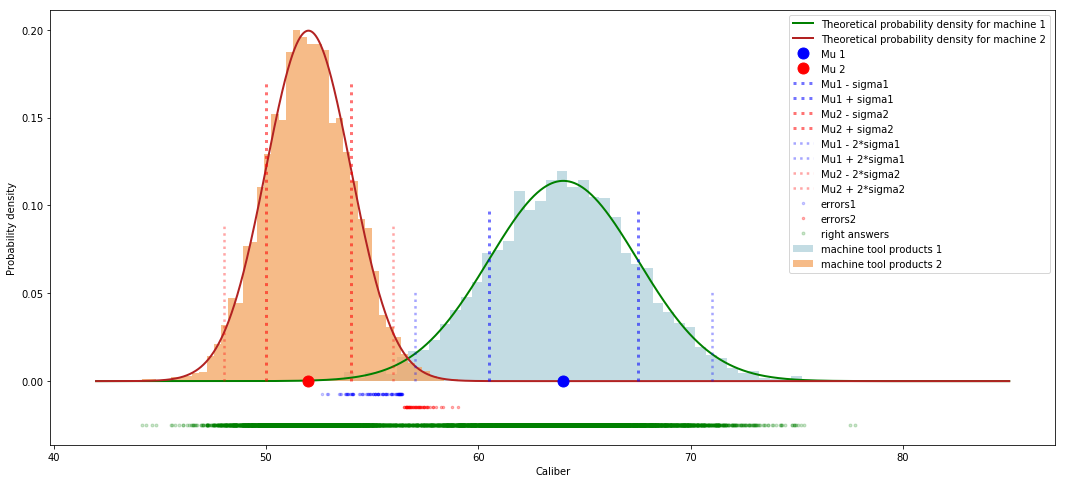

In [4]:
X = np.zeros((N))
np.random.seed(seed=42)
# инициализируем данные по деталям, производства станка №1
X[:N1] = np.random.normal(loc=mu_1, scale=sigma_1, size=N1)
# инициализируем детали, производства станка №2
X[N1:N] = np.random.normal(loc=mu_2, scale=sigma_2, size=N2)

# инициализируем вектор ответов
y = np.zeros((N))
y[:N1] = np.array((1))
y[N1:N] = np.array((2))

# определим априорную вероятность извлечь изделие, произведенное на станке №1
w1 = float(N1)/N
# определим априорную вероятность извлечь изделие, произведенное на станке №2
w2 = float(N2)/N

# для каждой детали определим вероятность принадлежности к тому или иному станку
proba_X = []
proba_X = proba_x(X, w1, w2, mu_1, mu_2, sigma_1, sigma_2)

# установим порог вероятности, при достижении которого, изделие будет относиться к тому или иному станку
limit_proba = 0.5

# определим принадлежность детали к станку
pred_X = []
pred_X = pred_x(proba_X, limit_proba)

# определим качество нашего алгоритма
print 'Доля верно определенных изделий:', round(accuracy_score(y, pred_X),3)
print

print 'График №1'
graph_01(X, pred_X, mu_1, sigma_1, mu_2, sigma_2)

Что мы только что сделали? Мы сгенерировали псевдослучайным образом 10000 значений, описываемых нормальным распределением, из них 6000 значений с математическим ожиданием в 64 мм и стандартным отклонением 4 мм, 4000 значений с математическим ожиданием равным 52 мм и стандартным отклонением в 2 мм. Далее, в соответствии с вышеуказанным алгоритмом, для каждой детали определили вероятность ее производства на станке №1 или №2. После этого выбрали гипотезу о производстве изделия на том или ином станке в зависимости от того, какая гипотеза имеет большую вероятность. И наконец сравнили результаты нашего алгоритма с истинными ответами.

На выходе мы получили долю правильных ответов - 0.986. В целом это очень неплохо, учитывая, что обучение мы проводили без использования истинных ответов.

Посмотрим на график. На что рекомендуется обратить внимание? Посмотрите, где расположены не верно определенные алгоритмом изделия. 

Во-первых, мы видим ошибки алгоритма только в той области, где изделия, произведенные на разных станках, имеют один и тот же диаметр. Это выглядит вполне логичным.

Во-вторых, мы видим, что алгоритм ошибается только в тех объектах, которые больше всего удалены от истинного среднего значения объектов и при этом находятся достаточно близко к ложному центру.

Но самое интересное в том, что проблемы начинаются в основном, после пересечения значений приблизительно равных $\mu +- 2\sigma $, конкретно в нашем случае на пересечении $\mu_1 - 2\sigma_1$ и $\mu_2 + 2\sigma_2$

Желающие могут "покрутить" параметры и посмотреть как меняется качество алгоритма. Это будет полезно для лучшего усвоения материала.

Ну а мы двигаемся дальше к следующему примеру

### Третий пример. Двумерный случай.

В этот раз мы рассмотрим случай, когда у нас есть данные не только о диаметре изделий, но и о, например, весе каждого изделия. Пускай станок №1 производит детали весом в 12 г. и стандартным отклонением в 1 г., станок №2 производит изделия весом в 10 г. и стандартным отклонением 0.8 мм

В остальном будем использовать данные из предыдущего примера, запишем их.

$N1 = 6000$, $\mu_{1 1} = 64$, $\sigma_{1 1} = 4$, $\mu_{1 2} = 14$, $\sigma_{1 2} = 1$

$N2 = 4000$, $\mu_{2 1} = 52$, $\sigma_{2 1} = 2$, $\mu_{2 2} = 10$, $\sigma_{2 2} = 0.9$

Ситуация та же - все детали перемешались в одну большую кучу и нам нужно их перебрать и определить для каждой детали вероятность ее производства на станке №1 и станке №2.

**Решение**

В целом подход решения относительно предыдущего примера не меняется за исключением формулы определения плотности вероятности случайной величины. Для многомерного случая используется следующая формула:

$$ p_{B_j}(x_i) = \frac{1}{(2\pi)^{k/2} \centerdot \mid \Sigma_j\mid ^{1/2}} \centerdot \exp(- \frac{1}{2} \centerdot (x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j)) $$

, где $\Sigma_j$ - это матрица ковариаций cлучайных величин $j$-й гипотезы (в нашем случае, матрица ковариаций параметров изделий, произведенных на $j$-м станке)

$\mid \Sigma_j\mid$ - это определитель матрицы ковариации случайных величин $j$-й гипотезы

$\mu_j$ - математическое ожидание случайных величин $j$-ой гипотезы (в нашем случае, среднее значение изделий, произведенных на $j$-м станке)

$x_i$ - случайная величина (в нашем случае параметры $i$-го изделия)

В этот раз, для понимания кода, уважаемому читателю понадобятся знания об операциях с матрицами

In [5]:
# функция определения плотности вероятности извлечь деталь, произведенную заданном на станке
# то есть мы задаем параметры станка: мат.ожидание, среднее кв. отклонение
def gaus_func_02(k, m, x, mu, sigma):
    pj_xi = []
    for j in range(k):
        det_sigma_j = np.linalg.det(sigma[j])
        factor_1 = 1 / (((2 * math.pi)**(k/2)) * ((det_sigma_j)**0.5))
        factor_2 = []
        for i in x:
# обратим внимание на то, что запись в коде отличается от записи показателя экспоненты в обшепринятой функции
# в общепринятом виде первым множетелем идет транспонированная матрица центрированных значений
# у нас наоборот. Это связано с тем, что мы изначально использовали иной формат
# спишем это на технические обстоятельства
            factor_2.append(math.e**float(
            -0.5 * np.matrix(i - mu[j]) * np.matrix(np.linalg.inv(sigma[j])) * np.matrix(i - mu[j]).T))
        pj_xi.append(factor_1 * np.array(factor_2))
    return np.array(pj_xi)

# напишем функцию определения вероятности того, что извлеченный объект относится к кластеру №1 и №2
def proba_func_02(pjxi, w, k):
    # для начала определим вероятность извлечь объект из всей совокупности данных
    P_X = []
    for j in range(k):
        P_X.append(w[j] * pjxi[j])
    P_X = np.sum(np.array(P_X), axis = 0)
    # теперь определим вероятность того, что извлеченный объект относится к кластеру №1 и №2
    P_J_X = []
    for j in range(k):
        P_J_X.append(w[j] * pjxi[j] / P_X)
    return np.array(P_J_X)

# напишем функцию отнесения изделия к тому или станку
def pred_x_02(proba_X, limit_proba):
    pred_X = []
    for x in proba_X[0]:
        if x >= limit_proba:
            pred_X.append(1)
        else:
            pred_X.append(2)
    return np.array(pred_X)

# напишем функцию построения графика с распределением изделий по станкам в соответствии с алгоритмом
def graph_02_algorithm(pred_X, mu):
    # преобразуем массив данных
    pred_X = np.array(pred_X)

    # запишем параметры изделий, в раздельные массивы в соответствии с определением станка алгоритмом
    answers_1 = []
    answers_2 = []

    for i in range(pred_X.shape[0]):
        if pred_X[i] == 1:
            answers_1.append(X[i])
        else:
            answers_2.append(X[i])
    
    print 'График "Распределение изделий в соответствии с алгоритмом"'
    plt.figure(figsize=(16, 6))  
    plt.plot(
        np.array(answers_1)[:,0], np.array(answers_1)[:,1], 'o', alpha = 0.7, color='sandybrown', label = 'Produced on machine #1')
    plt.plot(
        np.array(answers_2)[:,0], np.array(answers_2)[:,1], 'o', alpha = 0.45, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'slateblue', label = 'Mu 2')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()
    
# напишем функцию построения графика с истинным распределением изделий по станкам
def graph_02_true(X, mu):
    print 'График "Истинное распределение изделий"'
    plt.figure(figsize=(16, 6))  
    plt.plot(
        X[0:N1,0], X[0:N1,1], 'o', alpha = 0.7, color='sandybrown', label = 'Produced on machine #1')
    plt.plot(
        X[N1:N,0], X[N1:N,1], 'o', alpha = 0.45, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'slateblue', label = 'Mu 2')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

In [6]:
# количество станков
k = 2

# количество деталей изготовленных на станке №1
N1 = 6000
# количество деталей изготовленных на станке №2
N2 = 4000
N = N1+N2

# количество признаков (диаметр и вес)
m = 2

# диаметр изделия станка №1
mu_1_1 = 64.
# вес изделия станка №1
mu_1_2 = 14.
# стандартные отклонения
sigma_1_1 = 3.5
sigma_1_2 = 1.

# диаметр изделия станка №2
mu_2_1 = 52.
# вес изделия станка №2
mu_2_2 = 9.5
# стандартные отклонения
sigma_2_1 = 2.
sigma_2_2 = 0.7

Доля верно определенных изделий: 0.998

График "Распределение изделий в соответствии с алгоритмом"


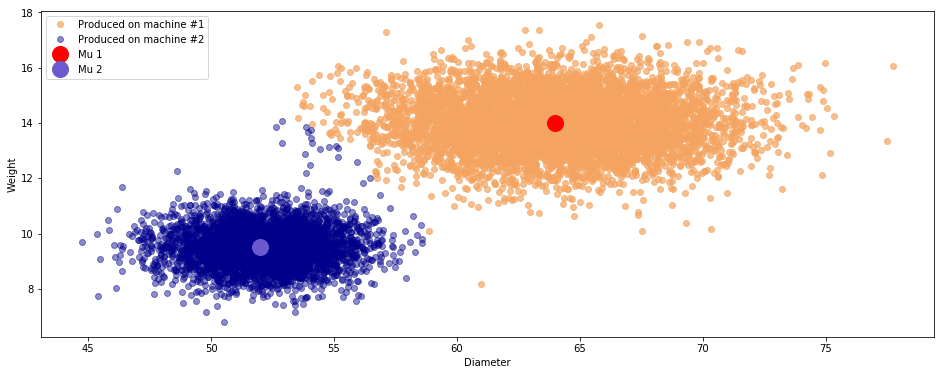

График "Истинное распределение изделий"


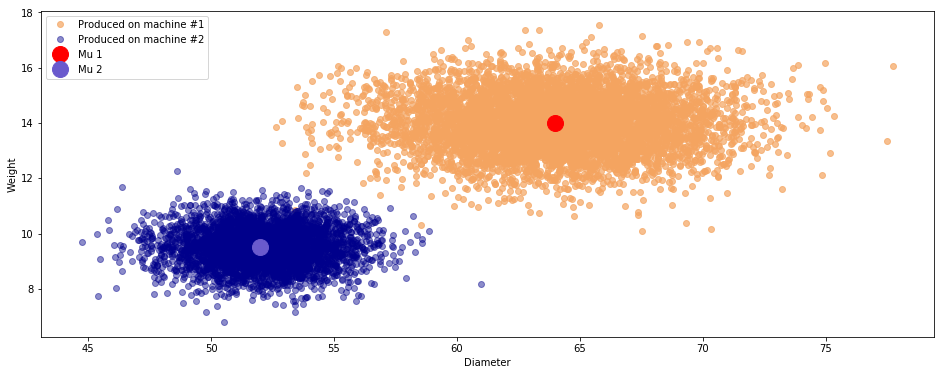

In [7]:
X = np.zeros((N, m))
np.random.seed(seed=42)
# инициализируем данные по деталям, производства станка №1
X[:N1, 0] = np.random.normal(loc=mu_1_1, scale=sigma_1_1, size=N1)
X[:N1, 1] = np.random.normal(loc=mu_1_2, scale=sigma_1_2, size=N1)
# инициализируем детали, производства станка №2
X[N1:N, 0] = np.random.normal(loc=mu_2_1, scale=sigma_2_1, size=N2)
X[N1:N, 1] = np.random.normal(loc=mu_2_2, scale=sigma_2_2, size=N2)

# зафиксируем правильные ответы (для оценки качества алгоритма, в обучении не используется)
y = np.zeros((N))
y[:N1] = np.array((1))
y[N1:N] = np.array((2))

# запишем средние значения диаметра и веса изделий в матричном формате (для удобства расчетов)
mu  = np.array(([mu_1_1, mu_1_2], [mu_2_1, mu_2_2]))

# запишем стандартные отклонения в формате матрицы ковариации (для удобства расчетов)
sigma = np.array(([sigma_1_1, 0.],[0., sigma_1_2], [sigma_2_1, 0.],[0., sigma_2_2]))
sigma = sigma.reshape(k, m, m)

# инициализируем априорную вероятность извлечь изделие, произведенное на станке №1 и №2
w = np.array([float(1./k), float(1./k)])

# запустим наши функции
pj_xi = gaus_func_02(k, m, X, mu, sigma)
proba_X = proba_func_02(pj_xi, w, m)

# установим порог вероятности, при достижении которого, изделие будет относиться к тому или иному станку
limit_proba = 0.5

pred_X = pred_x_02(proba_X, limit_proba)
        
# определим качество нашего алгоритма
print 'Доля верно определенных изделий:', round(accuracy_score(y, pred_X),3)
print

graph_02_algorithm(pred_X, mu)

graph_02_true(X, mu)

По аналогии с предыдущим примером мы сгенерировали 10000 значений в соответствии с указанными выше параметрами $\mu$ и $\sigma$, написали несколько функций для работы нашего алгоритма и запустили его. Принципиальное отличие этого кода от кода из предыдущего примера состоит в том, что мы использовали на этот раз матричные выражения для проведения вычислений.

В результате наш алгоритм показывает долю правильных ответов равную 0.998, что собственно весьма неплохо.

Проблемы как мы видим, все там же - ошибки в деталях, которые были произведены на разных станках и при этом имеют схожие размеры и вес.

Код написан таким образом, чтобы читатель смог подставить любые значения параметров $\mu$ и $\sigma$ и посмотреть, как будет работать алгоритм: в каких случаях качество будет ухудшаться, в каких улучшаться. Главное при этом не забывать изучать график. Ну а мы двигаемся к нашему конечному пункту разбора EM-алгоритма, собственно самому EM-алгоритму.

### Встречаем EM-алгоритм

Продолжим наш пример с поступившими на склад деталями. Но на этот раз мы будем знать только то, что изделия были произведены на двух различных станках, их 10000, каждая деталь имеет диаметр и размер и более ничего нам не известно. Но задание не изменилось - нам также, как и раньше, из всей большой кучи, случайно перемешанных изделий, нужно будет определить к какому станку относится та или иная деталь. 

На первый взгляд звучит почти не реально, но на самом деле у нас в руках мощный инструментарий: формула Байеса и формула плотности вероятности случайной величины. Давайте всем этим добром и воспользуемся.

Как мы поступим? Как и положено в EM-алгоритме мы для начала инициализируем параметры:

Вероятность гипотезы извлечь деталь, произведенную на станке №1 - $w_1$ мы определим равной вероятности гипотезы извлечь деталь, произведенной на станке №2 - $w_2$. Гипотез всего две, а значит каждая из них на первом шаге будет равна 0.5.

Математическое ожидание случайных величин $\mu$ определим следующим образом. Перемешаем все изделия с помощью функции random, поделим совокупность поровну на две части, для каждой части по каждому параметру (диаметр, вес) определим среднее значение. 

Стандартное отклонение $\sigma$ возьмем, что называется с потолка - установим его равным единице по всем параметрам. Запишем в формате матрицы ковариации.

Мы готовы сделать первый E-шаг алгоритма. Используя инициализированные параметры случайных величин, определяем вероятность каждой детали быть отнесенной к станку №1 или станку №2. 

Собственно, таким образом, мы сделали первый E-шаг.

Теперь дело за M-шагом. Здесь все просто. После того, как мы определили вероятность каждой детали быть произведенной на том или ином станке, мы можем заново пересчитать вероятность каждой гипотезы - $w_1$, $w_2$, а также $\mu$ и $\sigma$.

Таких итераций, по два шага каждая, мы сделаем 15.

Смотрим код.

In [8]:
# запишем функцию E-шага
def e_step(x, k, m, n, w, mu, sigma):
    # инициализируем массив плотностей вероятностей извлечения i-ой детали из произведенных на j-м станке 
    pj_xi = []
    for j in range(k):
        det_sigma_j = np.linalg.det(sigma[j])
        factor_1 = 1 / (((2 * math.pi)**(k/2)) * ((det_sigma_j)**0.5))
        factor_2 = []
        for i in x:
            factor_2.append(math.e**float(
                -0.5 * np.matrix(i - mu[j]) * np.matrix(np.linalg.inv(sigma[j])) * np.matrix(i - mu[j]).T))
        pj_xi.append(factor_1 * np.array(factor_2))
    pj_xi = np.array(pj_xi)
    
    # инициализируем массив плотностей вероятностей того, что i-я деталь произведена на j-м станке
    pj_xi_w = []
    for j in range(k):
        pj_xi_w.append(pj_xi[j] * w[j])
    pj_xi_w = np.array(pj_xi_w)
    
    # рассчитаем плотность вероятности извлечения i-й детали среди всех деталей  
    sum_pj_xi_w = np.sum(pj_xi_w, axis = 0)
    
    # инициализируем массив вероятностей отнесения каждой детали к каждому станку
    proba_xi = []
    for j in range(k):
        proba_xi.append(pj_xi_w[j] / sum_pj_xi_w)
    
    return np.array(proba_xi)

# запишем функцию, в соответствии с которой, на основании данных о вероятности отнесения изделия к тому или иному станку,
# будет определятся на каком станке изделие производилось
def x_new(proba_xi):
    X1_new_ind = []
    X2_new_ind = []
    X_answers = []

    count = 0
    for x in proba_xi[0]:
        if x >= 0.5:
            X1_new_ind.append(count)
            X_answers.append(1)
        else:
            X2_new_ind.append(count)
            X_answers.append(2)
        count += 1
    # на выходе получаем вектор индексов изделий, произведенных на станке №1, №2 и вектор ответов
    return X1_new_ind, X2_new_ind, X_answers


# запишем функцию M-шага
def m_step(x, proba_xi,N):
    w_new = np.sum(proba_xi, axis = 1) / N
    
    # рассчитаем математическое ожидание
    mu_new = (np.array((np.matrix(proba_xi) * np.matrix(X))).T / np.sum(proba_xi, axis = 1)).T
    
    # рассчитаем дисперсии
    cov_new = []
    for mu in range(mu_new.shape[0]):
        X_cd = []
        X_cd_proba = []
        count = 0
        for x_i in x:
            cd = np.array(x_i - mu_new[mu])
            X_cd.append(cd)
            X_cd_proba.append(cd * proba_xi[mu][count])
            count += 1
        X_cd = np.array(X_cd)
        X_cd = X_cd.reshape(N, m)
        X_cd_proba = np.array(X_cd_proba)
        X_cd_proba = X_cd_proba.reshape(N, m)

        cov_new.append(np.matrix(X_cd.T) * np.matrix(X_cd_proba))
    cov_new = np.array((np.array(cov_new) / (np.sum(proba_xi, axis = 1)-1)))
    # при расчете матрицы ковариации в некоторых случаях могут быть элементы с отрицательными значениями, переведем их в нули
    # на основной рассчет такой перевод не повлияет, но упростит извлечение корня из значений матрицы ковариации
    if cov_new[0][0][1] < 0:
        cov_new[0][0][1] = 0
    if cov_new[0][1][0] < 0:
        cov_new[0][1][0] = 0
    
    if cov_new[1][0][1] < 0:
        cov_new[1][0][1] = 0
    if cov_new[1][1][0] < 0:
        cov_new[1][1][0] = 0
    
    # рассчитаем стандартное отклонение
    sigma_new = cov_new**0.5
    return w_new, mu_new, sigma_new

In [9]:
# сформируем исходные условия
# количество изделий произведенных на станке №1 (кластер 1)
N1 = 6000
# количество изделий произведенных на станке №2 (кластер 2)
N2 = 4000
# суммарное количество изделий произведенных на обоих станках
N = N1 + N2

# количество станков
k = 2

# диаметр изделий станка №1
mu_samples_1_1 = 64.
# вес изделий станка №1
mu_samples_1_2 = 14.

# диаметр изделий станка №2
mu_samples_2_1 = 52.
# вес изделий станка №2
mu_samples_2_2 = 9.5

# стандартное отклонение диаметров изделий станка №1
sigma_samples_1_1 = 3.5
# стандартное отклонение веса изделий станка №1
sigma_samples_1_2 = 1.

# стандартное отклонение диаметров изделий станка №2
sigma_samples_2_1 = 2.
# стандартное отклонение веса изделий станка №2
sigma_samples_2_2 = 0.7

In [10]:
X = np.zeros((N, 2))

np.random.seed(seed=42)
# инициализируем данные по деталям, произведенных на станке №1
X[:N1, 0] = np.random.normal(loc=mu_samples_1_1, scale=sigma_samples_1_1, size=N1)
X[:N1, 1] = np.random.normal(loc=mu_samples_1_2, scale=sigma_samples_1_2, size=N1)
# инициализируем данные по деталям, произведенных на станке №2
X[N1:N, 0] = np.random.normal(loc=mu_samples_2_1, scale=sigma_samples_2_1, size=N2)
X[N1:N, 1] = np.random.normal(loc=mu_samples_2_2, scale=sigma_samples_2_2, size=N2)

# зафиксируем количество признаков
m = X.shape[1]

# зафиксируем количество объектов
n = X.shape[0]

# зафиксируем правильные ответы для оценки качества алгоритма (в обучении не используется)
y = np.zeros((N))
y[:N1] = np.array((1))
y[N1:N] = np.array((2))

# инициализируем априорную вероятность извлечь изделие, произведенное на станке №1 и №2
w = np.array([float(1./k), float(1./k)])

np.random.seed(seed = None)
# инициализируем средние значения диаметра и веса изделий (запишем в формате матрицы)
mu  = np.array(
    (np.mean(X[np.random.choice(n, n/k)], axis = 0), np.mean(X[np.random.choice(n, n/k)], axis = 0)))
# mu = np.array(([mu_samples_1_1, mu_samples_1_2],[mu_samples_2_1, mu_samples_2_2]))

# инициализируем стандартные отклонения в диаметре и весе изделий (запишем в формате матрицы ковариации)
sigma = np.array(([1., 0.],[0., 1.], [1., 0.],[0., 1.]))
# sigma = np.array(([sigma_samples_1_1, 0.],[0., sigma_samples_1_2], [sigma_samples_2_1, 0.],[0., sigma_samples_2_2]))
sigma = sigma.reshape(k, m, m)

Итерация № 1

Матрица значений математических ожиданий
[[63.87544507 13.70338527]
 [54.34450024 10.63218808]]

Матрица значений стандартных отклонений
[[[4.30236937 1.82973835]
  [1.79067614 1.52351522]]

 [[4.64457489 2.80998218]
  [2.74999323 2.0798739 ]]]

Доля правильно распознанных изделий
0.961


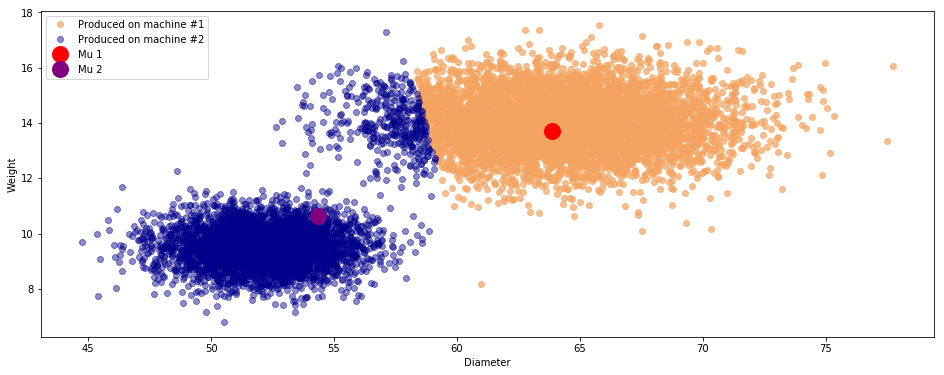

Итерация № 2

Матрица значений математических ожиданий
[[64.79537093 13.85047645]
 [53.22170366 10.43065208]]

Матрица значений стандартных отклонений
[[[2.99166574 0.97378641]
  [0.93999728 1.18949144]]

 [[3.13633679 2.26499767]
  [2.18640519 2.03931626]]]

Доля правильно распознанных изделий
0.904


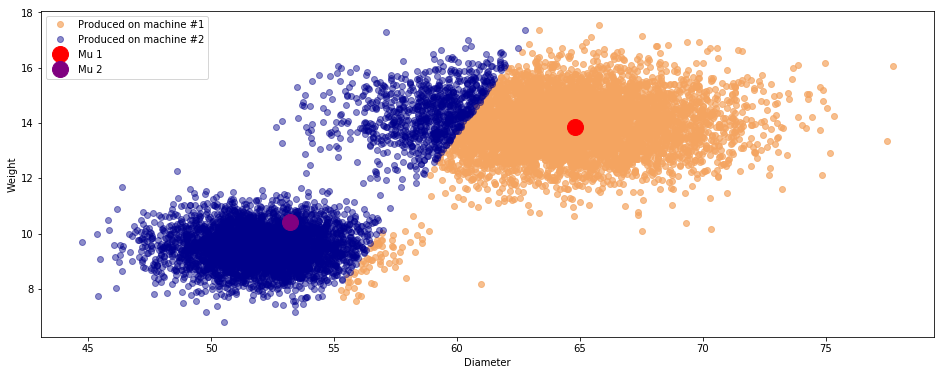

Итерация № 3

Матрица значений математических ожиданий
[[64.59015827 13.89090253]
 [52.79002043 10.18238723]]

Матрица значений стандартных отклонений
[[[3.05079937 0.87594471]
  [0.80148219 1.2188196 ]]

 [[2.55986909 1.87986073]
  [1.72005707 1.82652956]]]

Доля правильно распознанных изделий
0.934


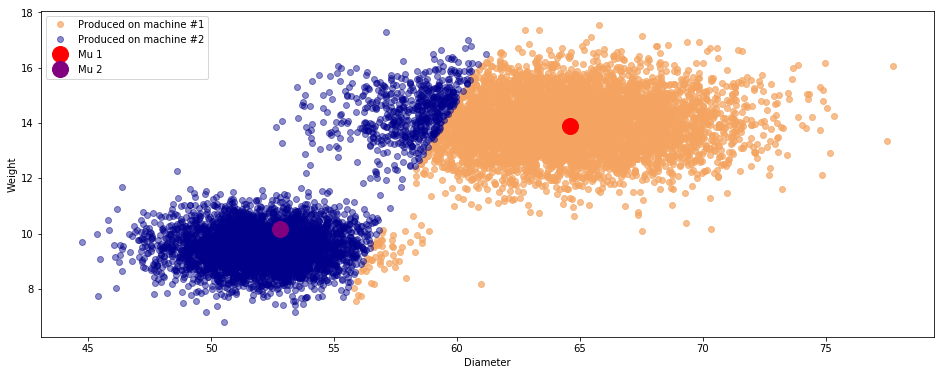

Итерация № 4

Матрица значений математических ожиданий
[[64.44046936 13.92197631]
 [52.52290477  9.99847195]]

Матрица значений стандартных отклонений
[[[3.11971391 0.75997143]
  [0.67178886 1.23784872]]

 [[2.20699425 1.54514432]
  [1.36585495 1.61621359]]]

Доля правильно распознанных изделий
0.952


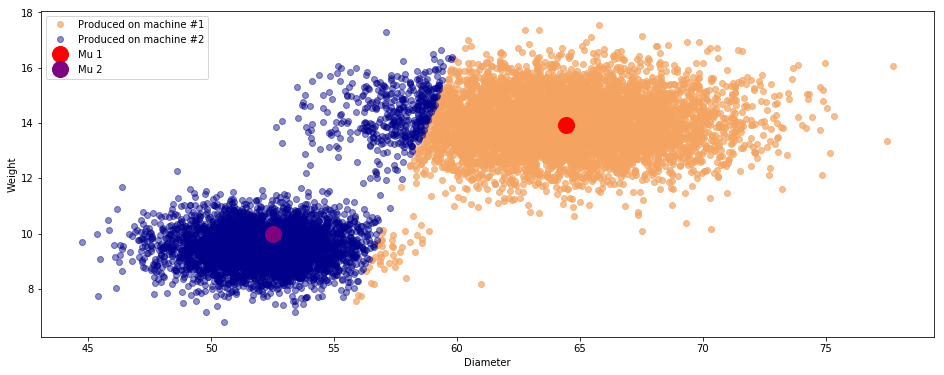

Итерация № 5

Матрица значений математических ожиданий
[[64.32857308 13.95020011]
 [52.34206304  9.85155403]]

Матрица значений стандартных отклонений
[[[3.18053869 0.59404303]
  [0.51257903 1.23744088]]

 [[1.96909566 1.22908924]
  [1.06053829 1.40724803]]]

Доля правильно распознанных изделий
0.968


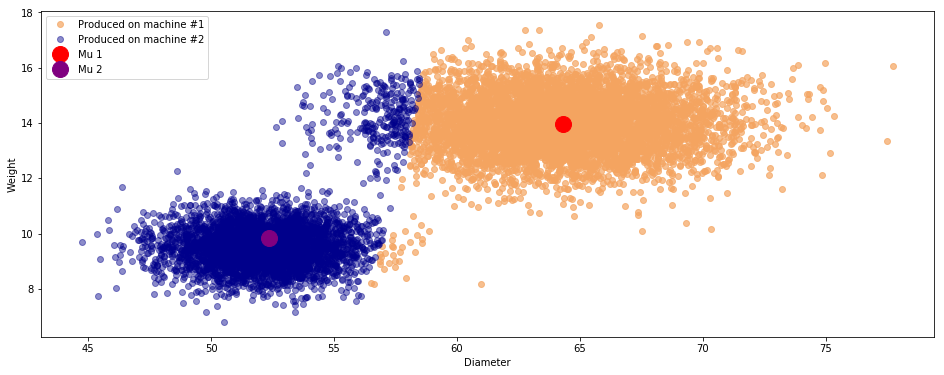

Итерация № 6

Матрица значений математических ожиданий
[[64.24070185 13.96992087]
 [52.22731859  9.74317528]]

Матрица значений стандартных отклонений
[[[3.24172606 0.4140017 ]
  [0.35122447 1.23137516]]

 [[1.82522897 0.9591901 ]
  [0.81374313 1.2230268 ]]]

Доля правильно распознанных изделий
0.978


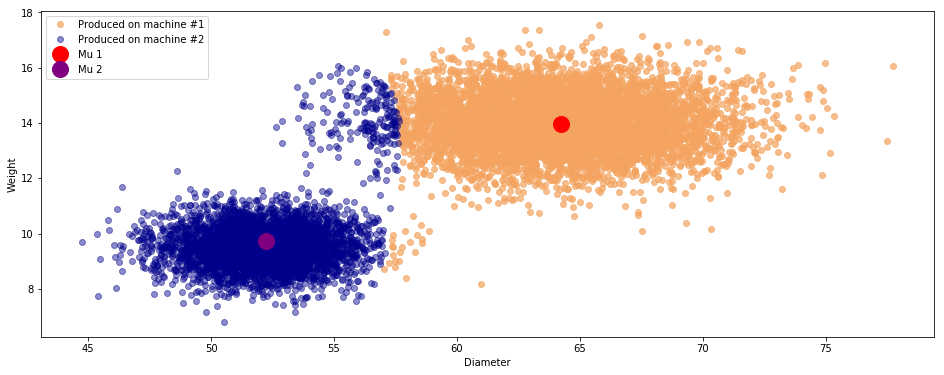

Итерация № 7

Матрица значений математических ожиданий
[[64.1598518  13.98298147]
 [52.14751694  9.6558198 ]]

Матрица значений стандартных отклонений
[[[3.31100992 0.19779244]
  [0.1655024  1.23105385]]

 [[1.73464145 0.70928269]
  [0.59349077 1.04379205]]]

Доля правильно распознанных изделий
0.986


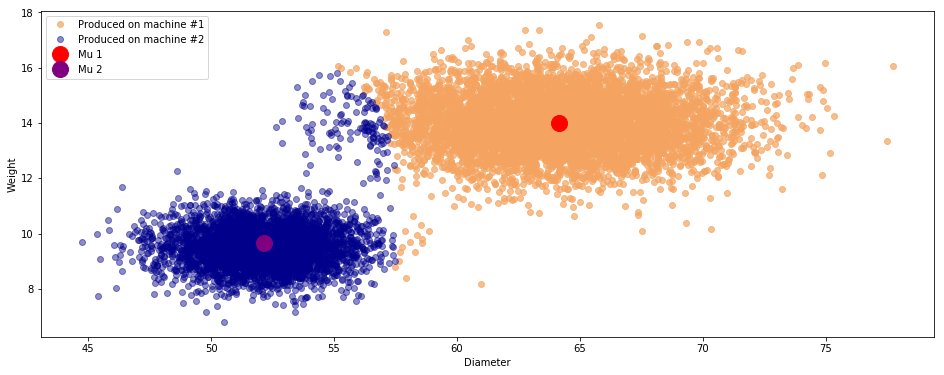

Итерация № 8

Матрица значений математических ожиданий
[[64.09785954 13.99047255]
 [52.09982269  9.59521612]]

Матрица значений стандартных отклонений
[[[3.37111147 0.        ]
  [0.         1.23001244]]

 [[1.68612111 0.50116887]
  [0.41531592 0.89928763]]]

Доля правильно распознанных изделий
0.991


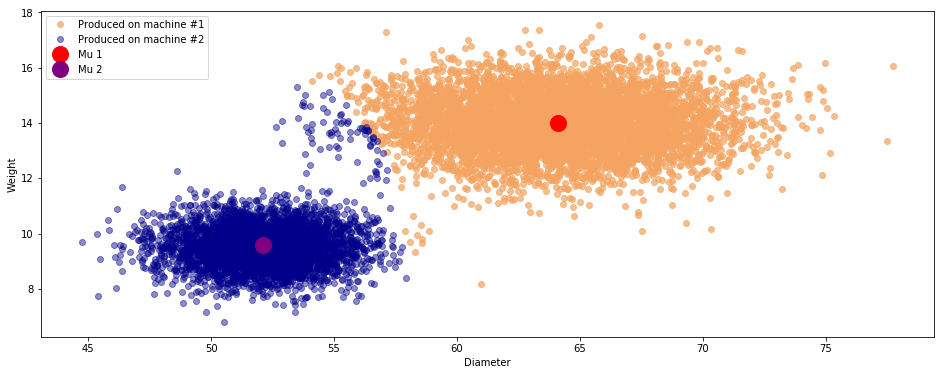

Итерация № 9

Матрица значений математических ожиданий
[[64.06188255 13.99254584]
 [52.07669792  9.56429838]]

Матрица значений стандартных отклонений
[[[3.40836352 0.        ]
  [0.         1.22939891]]

 [[1.6645532  0.36875705]
  [0.30396556 0.82137035]]]

Доля правильно распознанных изделий
0.995


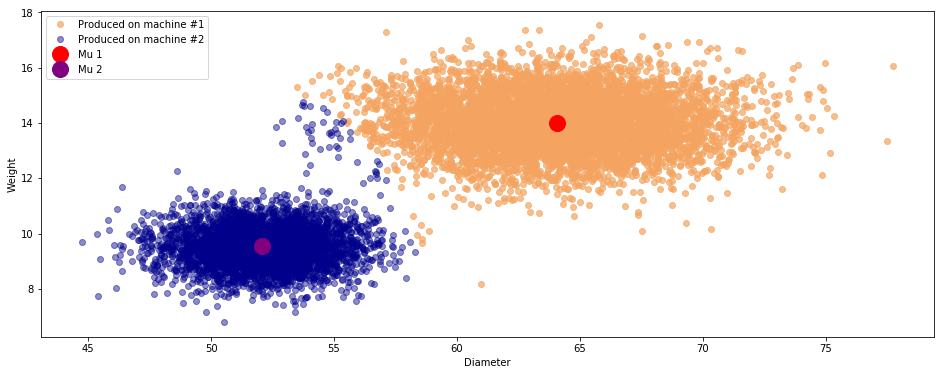

Итерация № 10

Матрица значений математических ожиданий
[[64.04408592 13.9922499 ]
 [52.06583664  9.55099616]]

Матрица значений стандартных отклонений
[[[3.42715306 0.        ]
  [0.         1.23134756]]

 [[1.6544004  0.30142226]
  [0.24781664 0.78707088]]]

Доля правильно распознанных изделий
0.996


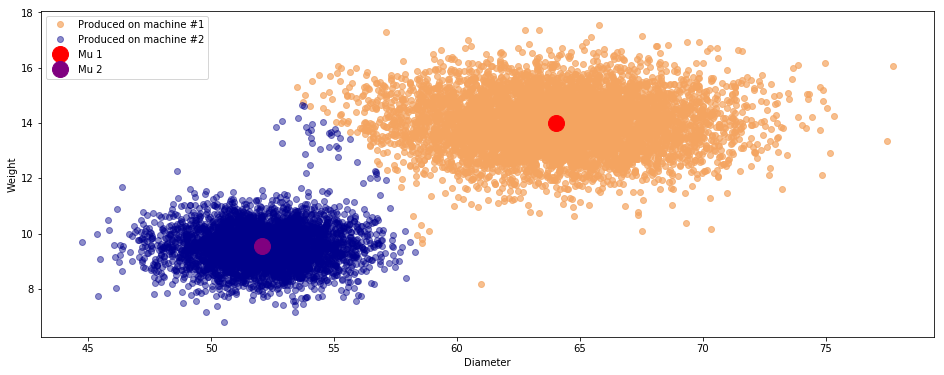

Итерация № 11

Матрица значений математических ожиданий
[[64.03657628 13.99194463]
 [52.06151681  9.54571918]]

Матрица значений стандартных отклонений
[[[3.43524493 0.        ]
  [0.         1.23242646]]

 [[1.65042287 0.27222655]
  [0.22357154 0.77338123]]]

Доля правильно распознанных изделий
0.996


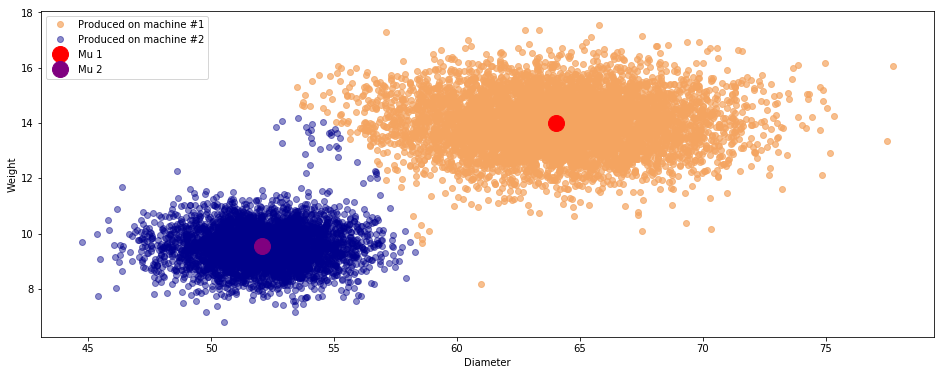

Итерация № 12

Матрица значений математических ожиданий
[[64.03356864 13.99177585]
 [52.05979973  9.54367513]]

Матрица значений стандартных отклонений
[[[3.43849011 0.        ]
  [0.         1.23291407]]

 [[1.64884444 0.26024096]
  [0.21363583 0.76813289]]]

Доля правильно распознанных изделий
0.996


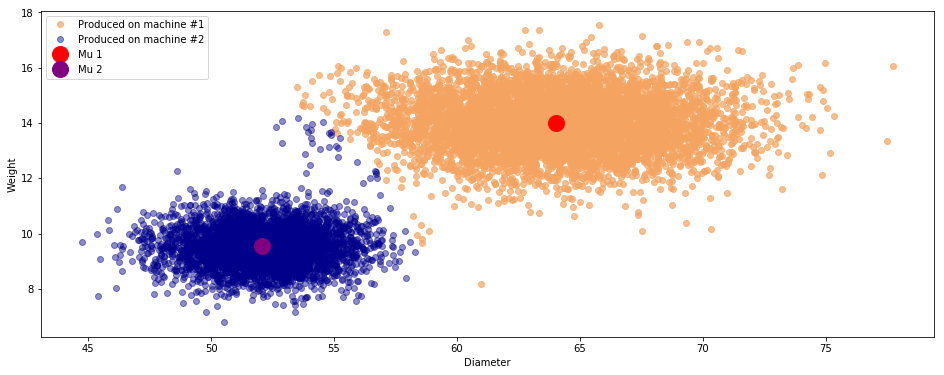

Итерация № 13

Матрица значений математических ожиданий
[[64.03238754 13.99170016]
 [52.05912254  9.54288467]]

Матрица значений стандартных отклонений
[[[3.43976177 0.        ]
  [0.         1.23311683]]

 [[1.64822063 0.25546284]
  [0.20967777 0.76611931]]]

Доля правильно распознанных изделий
0.996


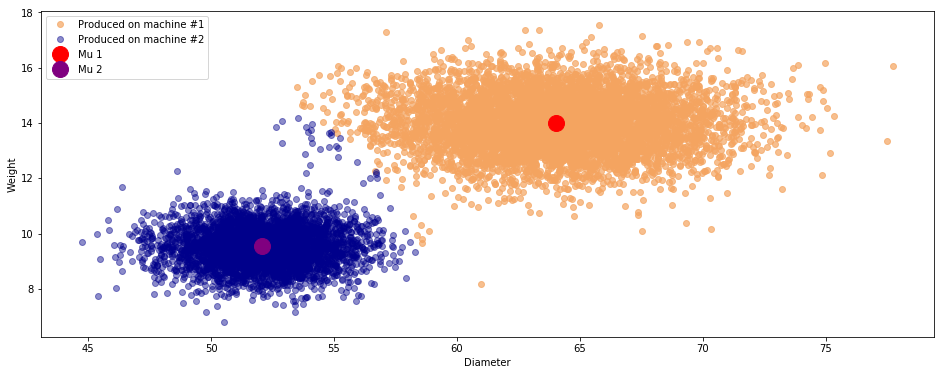

Итерация № 14

Матрица значений математических ожиданий
[[64.03192684 13.99166901]
 [52.05885754  9.54257833]]

Матрица значений стандартных отклонений
[[[3.44025712 0.        ]
  [0.         1.23319794]]

 [[1.64797616 0.25358637]
  [0.2081238  0.76534195]]]

Доля правильно распознанных изделий
0.997


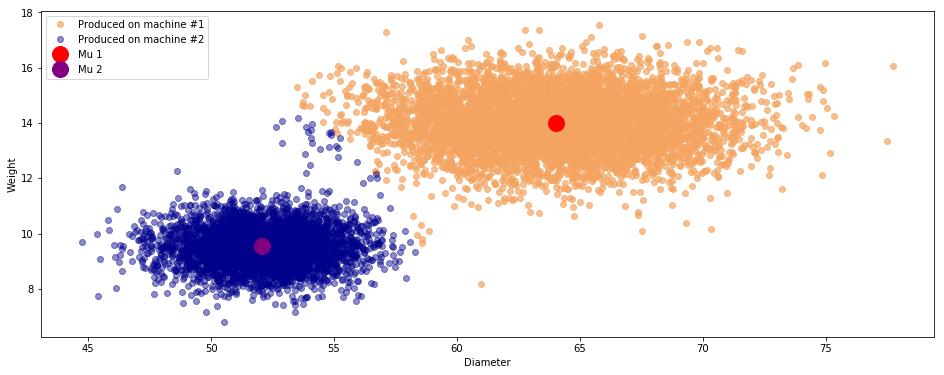

Итерация № 15

Матрица значений математических ожиданий
[[64.03174758 13.99165663]
 [52.05875427  9.54245944]]

Матрица значений стандартных отклонений
[[[3.44044974 0.        ]
  [0.         1.23322984]]

 [[1.64788082 0.25285419]
  [0.20751753 0.76504075]]]

Доля правильно распознанных изделий
0.997


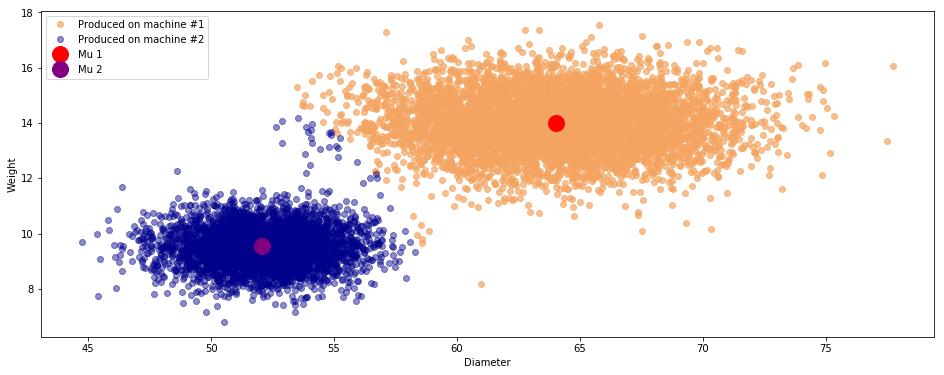

In [11]:
# выберем количество итераций EM-алгоритма
steps = 15
# запустим цикл EM-алгоритма
for i in range(steps):
    proba_xi = e_step(X, k, m, n, w, mu, sigma)
    w, mu, sigma = m_step(X, proba_xi,N)
    X1_new_ind, X2_new_ind, X_answers = x_new(proba_xi)
    print 'Итерация №', i+1
    print
    print 'Матрица значений математических ожиданий'
    print mu
    print
    print 'Матрица значений стандартных отклонений'
    print sigma
    print
    print 'Доля правильно распознанных изделий'
    print round(accuracy_score(y, X_answers),3)
    
    plt.figure(figsize=(16, 6))  
    plt.plot(
        X[X1_new_ind,0], X[X1_new_ind,1], 'o', alpha = 0.7, color='sandybrown', label = 'Produced on machine #1')
    plt.plot(
        X[X2_new_ind,0], X[X2_new_ind,1], 'o', alpha = 0.45, color = 'darkblue', label = 'Produced on machine #2')
    plt.plot(mu[0][0], mu[0][1], 'o', markersize = 16, color = 'red', label = 'Mu 1')
    plt.plot(mu[1][0], mu[1][1], 'o',  markersize = 16, color = 'purple', label = 'Mu 2')
    plt.xlabel('Diameter')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

Что в итоге получилось? А получилось следующее, не имея никакой предварительной информации о вероятности гипотез извлечения деталей, произведенных на станке №1 - $w_1$ или станке №2 $w_2$, математическом ожидании и стандартном отклонении случайных величин - $\mu$ и $\sigma$, мы достигли качество сопоставимое с предыдущим примером, в котором все вышеобозначенные параметры были известны.

Сравним параметры, которые мы задали при генерации совокупности изделий, так называемые истинные параметры и параметры, которые нам определил EM-алгоритм:

**Истинные параметры**

$\mu_{11} = 64$, $\mu_{12} = 14$, $\sigma_{11} = 3.5$, $\sigma_{12} = 1.$

$\mu_{21} = 52$, $\mu_{12} = 9.5$, $\sigma_{21} = 2.0$, $\sigma_{22} = 0.7$

**Определенные параметры**

$\mu_{11} \approx 64.03$, $\mu_{12} \approx 13.99$, $\sigma_{11} \approx 3.44$, $\sigma_{12} \approx 1.23$

$\mu_{21} \approx 52.06$, $\mu_{12} \approx 9.54$, $\sigma_{21} \approx 1.65$, $\sigma_{22} \approx 0.77$

На этом статья подходит к концу. Напоследок добавлю, что для целей анализа данных не имеет смысл изобретать велосипед и писать самостоятельно EM-алгоритм, можно просто воспользоваться предусмотренной функцией библиотеки sklearn.

Давайте посмотрим как отработает GaussianMixture библиотеки sklearn наш пример.

In [14]:
from sklearn.mixture import GaussianMixture as GMM

In [15]:
# сформируем исходные условия
# количество изделий произведенных на станке №1 (кластер 1)
N1 = 6000
# количество изделий произведенных на станке №2 (кластер 2)
N2 = 4000
# суммарное количество изделий произведенных на обоих станках
N = N1 + N2

# диаметр изделий станка №1
mu_samples_1_1 = 64.
# вес изделий станка №1
mu_samples_1_2 = 14.

# диаметр изделий станка №2
mu_samples_2_1 = 52.
# вес изделий станка №2
mu_samples_2_2 = 9.5

# стандартное отклонение диаметров изделий станка №1
sigma_samples_1_1 = 3.5
# стандартное отклонение веса изделий станка №1
sigma_samples_1_2 = 1.

# стандартное отклонение диаметров изделий станка №2
sigma_samples_2_1 = 2.
# стандартное отклонение веса изделий станка №2
sigma_samples_2_2 = 0.7


# количество станков
k = 2

X = np.zeros((N, 2))

np.random.seed(seed=42)
# инициализируем данные по деталям, произведенных на станке №1
X[:N1, 0] = np.random.normal(loc=mu_samples_1_1, scale=sigma_samples_1_1, size=N1)
X[:N1, 1] = np.random.normal(loc=mu_samples_1_2, scale=sigma_samples_1_2, size=N1)
# инициализируем данные по деталям, произведенных на станке №2
X[N1:N, 0] = np.random.normal(loc=mu_samples_2_1, scale=sigma_samples_2_1, size=N2)
X[N1:N, 1] = np.random.normal(loc=mu_samples_2_2, scale=sigma_samples_2_2, size=N2)

# зафиксируем правильные ответы для оценки качества алгоритма (в обучении не используется)
y = np.zeros((N))
y[:N1] = np.array((1))
y[N1:N] = np.array((2))

In [16]:
np.random.seed(1)
model = GMM(n_components=k, covariance_type='full')
model.fit(X)


temp_predict_X = model.predict(X)
X_answers = []
for i in range(X.shape[0]):
    if temp_predict_X[i] == 0:
        X_answers.append(1)
    else:
        X_answers.append(2)
        

print 'Доля правильно распознанных изделий'
print round(accuracy_score(y, X_answers),3)

Доля правильно распознанных изделий
1.0


Отработал на ура! Что и следовало ожидать, GaussianMixture библиотеки sklearn работает быстрее и качественнее нашего алгоритма. Однако цель статьи, как мы помним заключалась в том, чтобы понять устройство работы EM-алгоритмы. Надеюсь, что цель была достигнута :)

### Источники информации

**Литература**

1) Прикладная статистика: Классификации и снижение размерности, С.А. Айвазян, В.М. Бухштабер, И.С. Енюков, Л.Д. Мешалкин, Москва, Финансы и статистика, 1989

**Интернет ресурсы**

1) Статья 'A Gentle Tutorial of the EM Algorithm and its Application to Parameter Estimation for Gaussian Mixture and Hidden Markov Models', International Computer Science Institute, Jeff A. Bilmes, 1998, http://www-prima.imag.fr/Prima/jlc/Courses/2006/ENSI2.SIRR/EM-tutorial.pdf

2) Презентация 'Mixture Models & EM-algorithm', NY University, David Sontag, http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture21.pdf

3) Курс 'Поиск структуры данных', https://www.coursera.org/learn/unsupervised-learning/lecture/2jhbI/expectation-maximization-em-alghoritm

4) Формула полной вероятности и формулы Байеса, http://mathprofi.ru/formula_polnoj_verojatnosti_formuly_bajesa.html

5) Функция 'sklearn.mixture.GaussianMixture', https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

6) Нормальное распределение, Википедия https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5

7) Многомерное нормальное распределение, Википедия https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5

8) https://github.com/diefimov/MTH594_MachineLearning/blob/master/ipython/Lecture10.ipynb

9) Статья про EM-алгоритм, https://neerc.ifmo.ru/wiki/index.php?title=EM-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC

10) Статья про EM-алгоритм, http://www.machinelearning.ru/wiki/index.php?title=EM_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%28%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%29